## Klasyfikacja ręcznie pisanych liczb - MNIST




#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

# Wnioski po po pierwszym zadaniu

W poprzednich zadaniach nie korzystaliśmy z sieci neuronowych i nie mam wniosków póki co które moglibyśmy zastosować w tym zadaniu (może potem coś sobie przypomnę)
Wnioski o których pamiętam:
- trzeba unikać wycieku danych

# Plan działania
Na początku wczytamy dane a potem zdefiniujemy wstępny model sieci którą potem będziemy ulepszać wykorzystując macierz pomyłek oraz metrykę dokładności.


# Wczytanie danych

In [39]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from sklearn.dummy import DummyClassifier
import helper as hlp

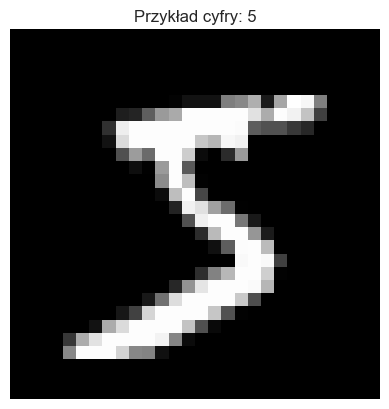

In [40]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
device = torch.device("cuda")

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

In [41]:
x_train.shape

(60000, 28, 28)

In [42]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [43]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [44]:
y_train.shape

(60000,)

# Zdefiniowanie przepływu

## Definicja Dataloader i dokładniejsze zbioru

In [45]:
# dla treningu i testu będą instancję tej klasy
class Minst_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# przed stworzeniem instancji musimy przekształcić x żeby zmnieszyć ilość wymiarów
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = x_train.reshape(-1, 28*28) # chcemy mieć jeden wektor z wszystkimi wartościami
x_test = x_test.reshape(-1, 28*28)

# Wydzielenie na zbiór walidacyjny
val_split = int(0.1 * len(x_train))
x_val, y_val = x_train[-val_split:], y_train[-val_split:]
x_train, y_train = x_train[:-val_split], y_train[:-val_split]


train_dataset = Minst_Dataset(x_train, y_train)
test_dataset = Minst_Dataset(x_test, y_test)
val_dataset = Minst_Dataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Rozmiar zbioru treningowego: {len(train_loader.dataset)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_loader.dataset)}")
print(f"Rozmiar zbioru testowego: {len(test_loader.dataset)}")

Rozmiar zbioru treningowego: 54000
Rozmiar zbioru walidacyjnego: 6000
Rozmiar zbioru testowego: 10000


## Sprawdzenie na dummy

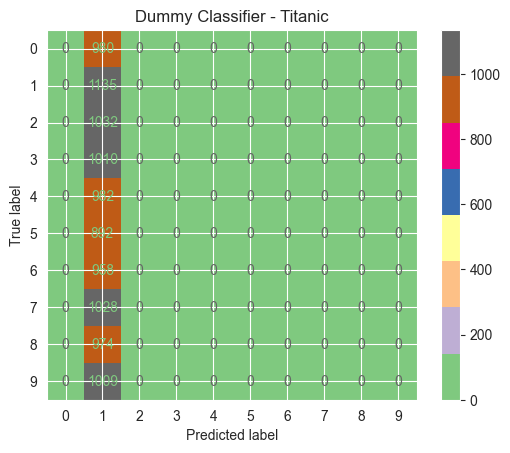

Accuracy: 0.1135

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jakub\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [46]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
y_pred = dummy.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy.classes_)
disp.plot(cmap="Accent")
plt.title("Dummy Classifier - Titanic")
plt.show()

# Metryki macierzy pomyłek
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Jak widać strategia wybierania najczęściej występującej liczby kompletnie się nie sprawdza

## Definicja sieci

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# tworzenie instancji modelu wejście 28*28 z powodu naszych danych
model = NeuralNetwork(input_size=28*28, hidden_size_1=128, hidden_size_2=64, output_size=10).to(device)

# Deklaracji funkcji straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr= 1e-3)

## deklaracja pętli treningowej

In [48]:
def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    all_preds = []
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        if not train:
            all_preds.append(preds.cpu())
    if not train:
        all_preds = torch.cat(all_preds).numpy()
    return epoch_loss / total, correct / total, all_preds

## Trening przykładowy
wystartujemy dla 5 epoch póki co, w przypadku pytania a dlaczego akurat 5 epok ? W tym przykładzie trenujemy sieć przez 5 epok – ta liczba jest ustawiona na sztywno tylko do testów. W praktyce liczba epok powinna wynikać z analizy krzywych treningowych (loss/accuracy). Jeżeli krzywa straty na zbiorze walidacyjnym przestaje się poprawiać, a na zbiorze treningowym nadal spada, to oznaka przeuczenia i należy przerwać uczenie (tzw. early stopping).

In [49]:
EPOCHS = 5

history = {"train_loss": [], "train_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, preds = run_epoch(train_loader, train=True)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f}")

print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.3091 acc 0.9123
Ep 02/5 | train loss 0.1293 acc 0.9615
Ep 03/5 | train loss 0.0847 acc 0.9740
Ep 04/5 | train loss 0.0609 acc 0.9818
Ep 05/5 | train loss 0.0471 acc 0.9856
Czas treningu: 23.6s


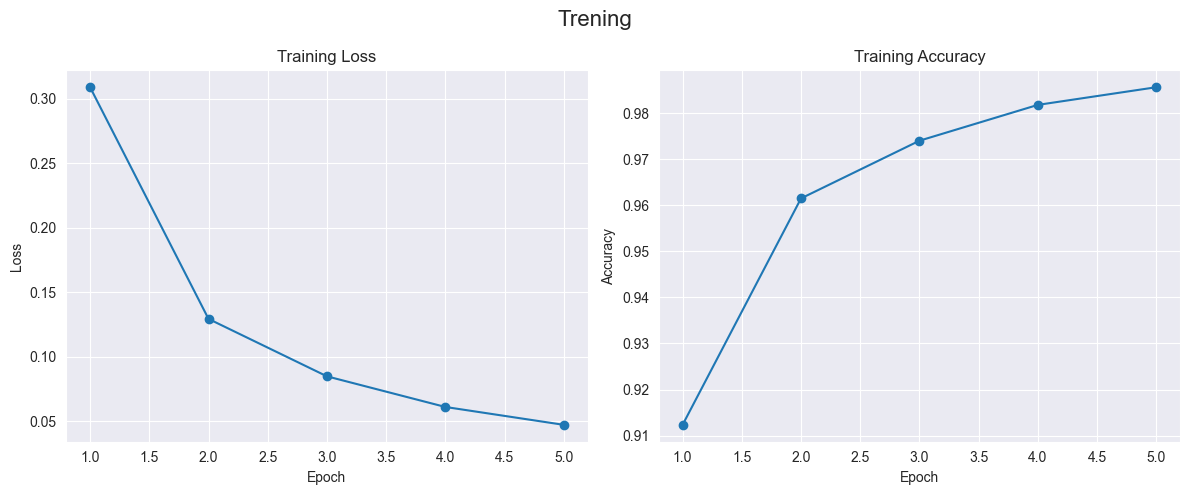

In [50]:
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

# Strata
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Dokładność
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.suptitle("Trening", fontsize=16)

plt.tight_layout()

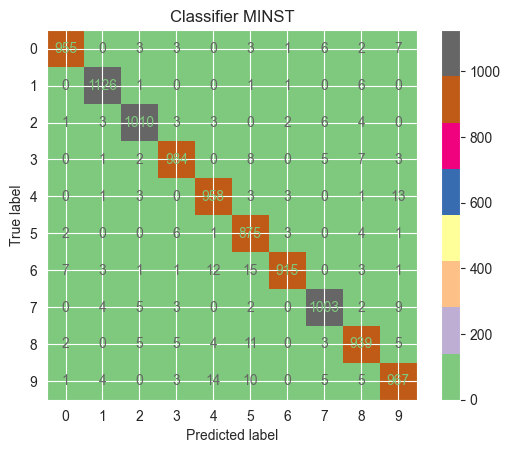

Accuracy: 0.9732

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.97      0.98      0.97       982
           5       0.94      0.98      0.96       892
           6       0.99      0.96      0.97       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [51]:
# sprawdźmy jak ten model radzi sobie z danymi testowymi
tr_loss, tr_acc, y_pred = run_epoch(test_loader, train=False)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Classifier MINST")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Widzimy że model osiągą już bardzo wysoką dokładność która zakrywa o overfitting ale z racji że rozdzieliliśmy zbiór testowy i treningowy nie grozi nam to, jestem też ciekaw czy model rozpozna moje własne pismo co zaraz sprawdzę

In [52]:
img = Image.open("5.jpg").convert("L")
img

In [53]:
img = np.array(img)
img = torch.tensor(img, dtype=torch.float32).to(device)
img = img.reshape(-1, 28*28)
logits = model(img)
preds = logits.argmax(1)
print(f"Wynik: {preds.item()}")

Wynik: 5


Elegancko model rozpoznał moje pismo teraz możemy się zastanowić czy nie dałoby się osiągnąć dokładności na poziomie 100

Spróbujemy zastosować early stopping *Wcześniejsze zatrzymywanie

Ep 01/100 | train loss 0.3116 acc 0.9116 | val loss 0.1334 acc 0.9605
Ep 02/100 | train loss 0.1323 acc 0.9603 | val loss 0.0980 acc 0.9702
Ep 03/100 | train loss 0.0890 acc 0.9726 | val loss 0.0916 acc 0.9715
Ep 04/100 | train loss 0.0639 acc 0.9810 | val loss 0.0903 acc 0.9743
Ep 05/100 | train loss 0.0489 acc 0.9849 | val loss 0.0969 acc 0.9735
Ep 06/100 | train loss 0.0380 acc 0.9880 | val loss 0.1018 acc 0.9740
Ep 07/100 | train loss 0.0310 acc 0.9904 | val loss 0.1226 acc 0.9688
Wcześniejsze zatrzymywanie 7
Czas treningu: 18.8s


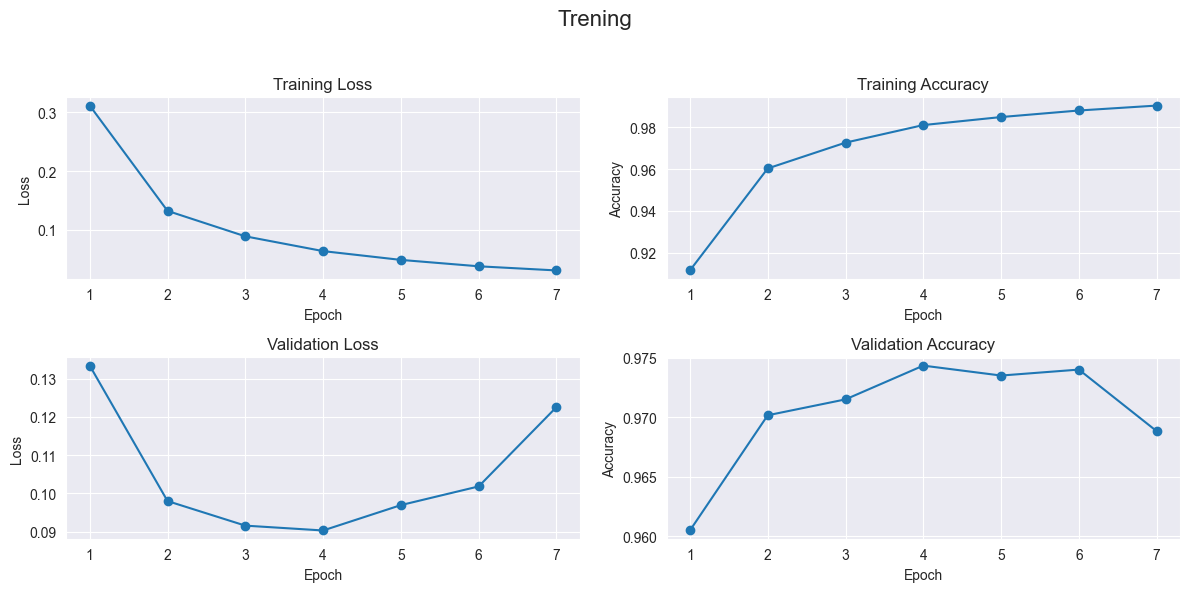

In [55]:
model = NeuralNetwork(input_size=28*28, hidden_size_1=128, hidden_size_2=64, output_size=10).to(device)
# Deklaracji funkcji straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr= 1e-3)

EPOCHS = 100 # maksymalnie ile dam epok możliwych
patience = 2
best_val_loss = float("inf")
patience_counter = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()

for epoch in range(1, EPOCHS+1):

    tr_loss, tr_acc, _ = run_epoch(train_loader, train=True)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)

    val_loss, val_acc, _ = run_epoch(val_loader, train=False)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Ep {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # zapisz najlepszy model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Wcześniejsze zatrzymywanie {epoch}")
            break

print(f"Czas treningu: {time.time()-start:.1f}s")

# Załaduj najlepszy model
model.load_state_dict(best_model_state)
epochs_range = range(1, len(history["train_loss"]) + 1)

# Trening
plt.figure(figsize=(12,6))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, history["train_loss"], marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history["train_acc"], marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 3)
plt.plot(epochs_range, history["val_loss"], marker='o')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 2, 4)
plt.plot(epochs_range, history["val_acc"], marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.suptitle("Trening", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

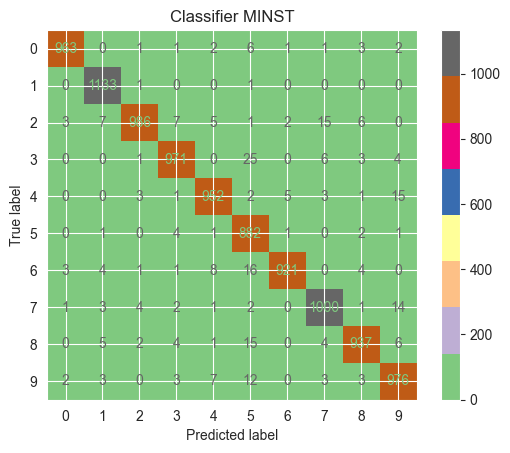

Accuracy: 0.9721

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.92      0.99      0.95       892
           6       0.99      0.96      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [56]:
# sprawdźmy jak ten model radzi sobie z danymi testowymi
tr_loss, tr_acc, y_pred = run_epoch(test_loader, train=False)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Accent")
plt.title("Classifier MINST")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Minimalnie poprawiliśmy dokładność modelu aby osiągnąć większą wymagana jest modyfikacja samego modelu

# Badanie Struktury sieci
spróbujemy pobawić się liczbą neuronów w celu dobrania ich w taki sposób żeby otrzymać jak najwyższą dokładność w tym celu porównam sobie różne liczby neuronów dla dwóch warstw [128, 64, 32, 16, 8]


 Test dla ilości neuronów 8, 8
Ep 01/100 | train loss 0.7957 acc 0.7528 | val loss 0.3981 acc 0.8848
Ep 02/100 | train loss 0.4244 acc 0.8784 | val loss 0.3479 acc 0.8990
Ep 03/100 | train loss 0.3794 acc 0.8918 | val loss 0.3173 acc 0.9053
Ep 04/100 | train loss 0.3471 acc 0.9014 | val loss 0.2908 acc 0.9137
Ep 05/100 | train loss 0.3210 acc 0.9088 | val loss 0.2715 acc 0.9172
Ep 06/100 | train loss 0.3024 acc 0.9141 | val loss 0.2581 acc 0.9220
Ep 07/100 | train loss 0.2900 acc 0.9178 | val loss 0.2492 acc 0.9267
Ep 08/100 | train loss 0.2813 acc 0.9205 | val loss 0.2435 acc 0.9282
Ep 09/100 | train loss 0.2750 acc 0.9221 | val loss 0.2380 acc 0.9287
Ep 10/100 | train loss 0.2698 acc 0.9231 | val loss 0.2344 acc 0.9300
Ep 11/100 | train loss 0.2657 acc 0.9238 | val loss 0.2320 acc 0.9318
Ep 12/100 | train loss 0.2620 acc 0.9249 | val loss 0.2296 acc 0.9315
Ep 13/100 | train loss 0.2588 acc 0.9256 | val loss 0.2287 acc 0.9307
Ep 14/100 | train loss 0.2561 acc 0.9264 | val loss 0.2272

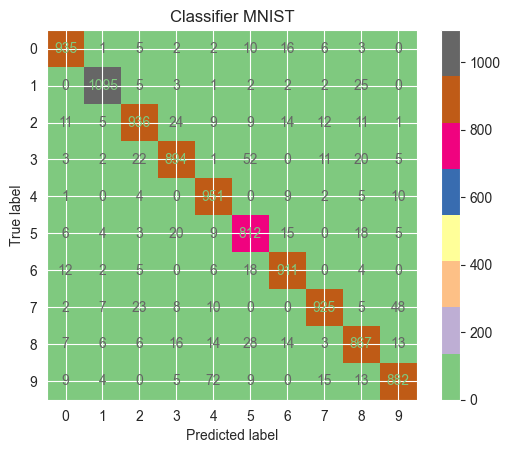

Accuracy: 0.9208

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.92      0.89      0.90      1010
           4       0.88      0.97      0.92       982
           5       0.86      0.91      0.89       892
           6       0.93      0.95      0.94       958
           7       0.95      0.90      0.92      1028
           8       0.89      0.89      0.89       974
           9       0.91      0.87      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


 Test dla ilości neuronów 8, 16
Ep 01/100 | train loss 0.6073 acc 0.8217 | val loss 0.3239 acc 0.9072
Ep 02/100 | train loss 0.3532 acc 0.8994 | val loss 0.2715 acc 0.9207
Ep 03/100 | train loss 0.3

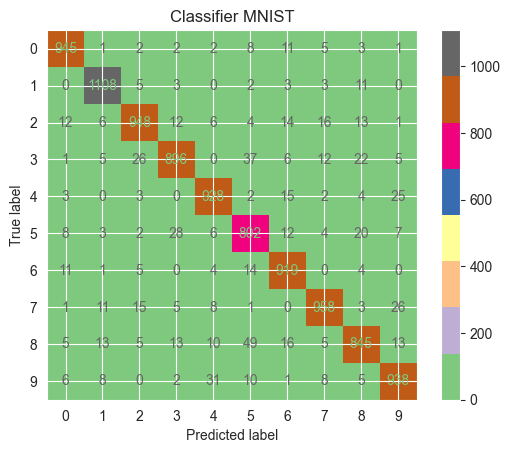

Accuracy: 0.9287

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.92      0.93      1032
           3       0.93      0.89      0.91      1010
           4       0.93      0.95      0.94       982
           5       0.86      0.90      0.88       892
           6       0.92      0.96      0.94       958
           7       0.95      0.93      0.94      1028
           8       0.91      0.87      0.89       974
           9       0.92      0.93      0.93      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


 Test dla ilości neuronów 8, 32
Ep 01/100 | train loss 0.5454 acc 0.8371 | val loss 0.2998 acc 0.9092
Ep 02/100 | train loss 0.3263 acc 0.9034 | val loss 0.2666 acc 0.9178
Ep 03/100 | train loss 0.2

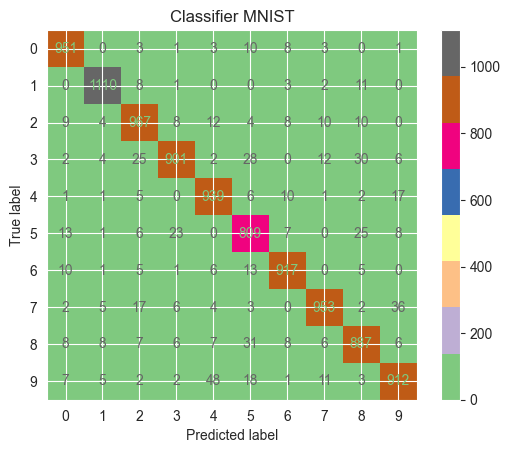

Accuracy: 0.9346

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.95      0.89      0.92      1010
           4       0.92      0.96      0.94       982
           5       0.88      0.91      0.89       892
           6       0.95      0.96      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.91      0.91      0.91       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


 Test dla ilości neuronów 8, 64
Ep 01/100 | train loss 0.4897 acc 0.8562 | val loss 0.2646 acc 0.9212
Ep 02/100 | train loss 0.2915 acc 0.9151 | val loss 0.2252 acc 0.9332
Ep 03/100 | train loss 0.2

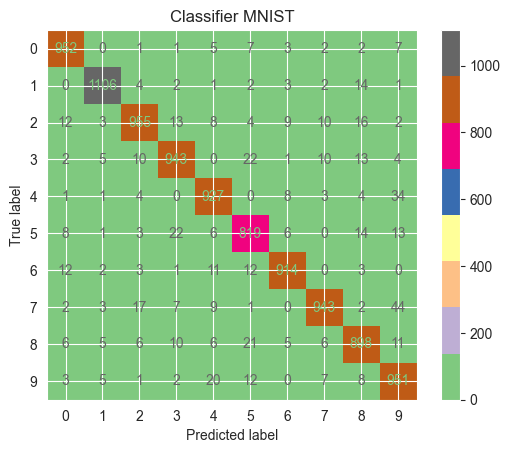

Accuracy: 0.9408

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.97      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.94      0.93      0.94      1010
           4       0.93      0.94      0.94       982
           5       0.91      0.92      0.91       892
           6       0.96      0.95      0.96       958
           7       0.96      0.92      0.94      1028
           8       0.92      0.92      0.92       974
           9       0.89      0.94      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


 Test dla ilości neuronów 8, 128
Ep 01/100 | train loss 0.5942 acc 0.8164 | val loss 0.3427 acc 0.8987
Ep 02/100 | train loss 0.3447 acc 0.8974 | val loss 0.2544 acc 0.9207
Ep 03/100 | train loss 0.

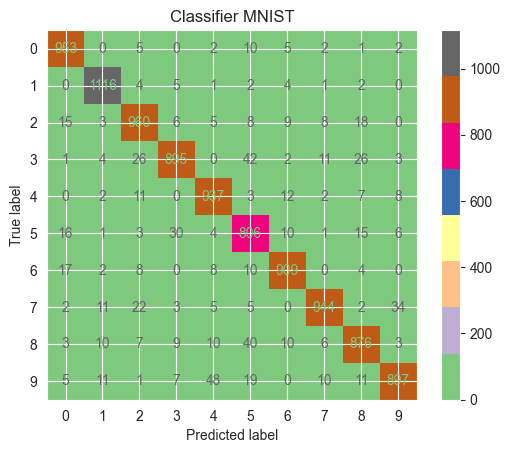

Accuracy: 0.9293

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.93      0.92      1032
           3       0.94      0.89      0.91      1010
           4       0.92      0.95      0.94       982
           5       0.85      0.90      0.88       892
           6       0.95      0.95      0.95       958
           7       0.96      0.92      0.94      1028
           8       0.91      0.90      0.90       974
           9       0.94      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


 Test dla ilości neuronów 16, 8
Ep 01/100 | train loss 0.6787 acc 0.7927 | val loss 0.3050 acc 0.9143
Ep 02/100 | train loss 0.3464 acc 0.9036 | val loss 0.2602 acc 0.9285
Ep 03/100 | train loss 0.3

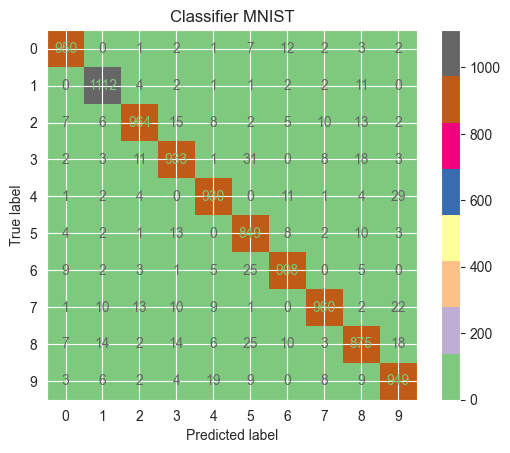

Accuracy: 0.943

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.96      0.93      0.95      1032
           3       0.94      0.92      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.89      0.95      0.92       892
           6       0.95      0.95      0.95       958
           7       0.96      0.93      0.95      1028
           8       0.92      0.90      0.91       974
           9       0.92      0.94      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


 Test dla ilości neuronów 16, 16
Ep 01/100 | train loss 0.5336 acc 0.8436 | val loss 0.2566 acc 0.9225
Ep 02/100 | train loss 0.2714 acc 0.9210 | val loss 0.2119 acc 0.9370
Ep 03/100 | train loss 0.2

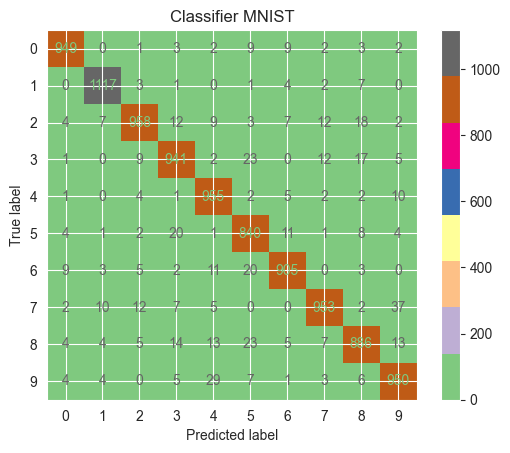

Accuracy: 0.9454

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.96      0.93      0.94      1032
           3       0.94      0.93      0.93      1010
           4       0.93      0.97      0.95       982
           5       0.91      0.94      0.92       892
           6       0.96      0.94      0.95       958
           7       0.96      0.93      0.94      1028
           8       0.93      0.91      0.92       974
           9       0.93      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.95      0.95     10000


 Test dla ilości neuronów 16, 32
Ep 01/100 | train loss 0.4766 acc 0.8682 | val loss 0.2448 acc 0.9250
Ep 02/100 | train loss 0.2735 acc 0.9207 | val loss 0.2067 acc 0.9402
Ep 03/100 | train loss 0.

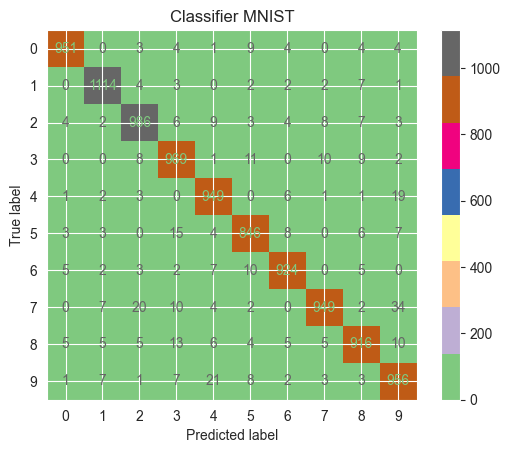

Accuracy: 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.95      0.95      0.95       892
           6       0.97      0.96      0.97       958
           7       0.97      0.92      0.95      1028
           8       0.95      0.94      0.95       974
           9       0.92      0.95      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 16, 64
Ep 01/100 | train loss 0.4394 acc 0.8749 | val loss 0.2171 acc 0.9365
Ep 02/100 | train loss 0.2340 acc 0.9320 | val loss 0.1692 acc 0.9528
Ep 03/100 | train loss 0.1

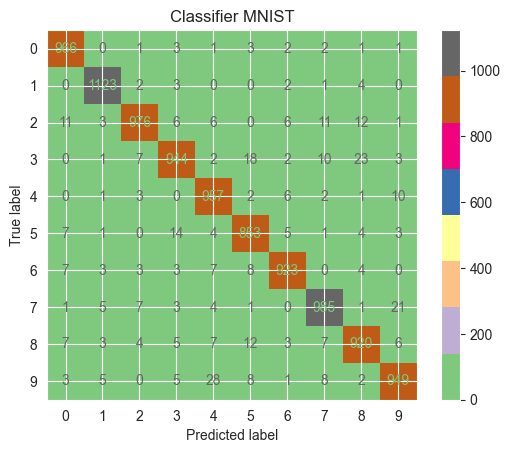

Accuracy: 0.9596

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.93      0.95      1010
           4       0.94      0.97      0.96       982
           5       0.94      0.96      0.95       892
           6       0.97      0.96      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 16, 128
Ep 01/100 | train loss 0.3995 acc 0.8839 | val loss 0.2040 acc 0.9363
Ep 02/100 | train loss 0.2196 acc 0.9343 | val loss 0.1655 acc 0.9502
Ep 03/100 | train loss 0

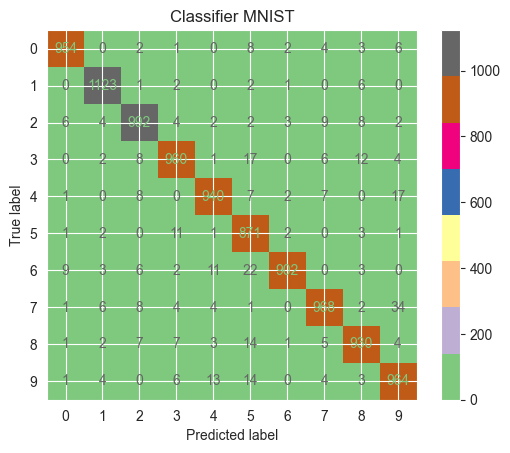

Accuracy: 0.9604

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.91      0.98      0.94       892
           6       0.99      0.94      0.96       958
           7       0.97      0.94      0.95      1028
           8       0.96      0.95      0.96       974
           9       0.93      0.96      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 32, 8
Ep 01/100 | train loss 0.5462 acc 0.8422 | val loss 0.2768 acc 0.9185
Ep 02/100 | train loss 0.2883 acc 0.9181 | val loss 0.2127 acc 0.9408
Ep 03/100 | train loss 0.2

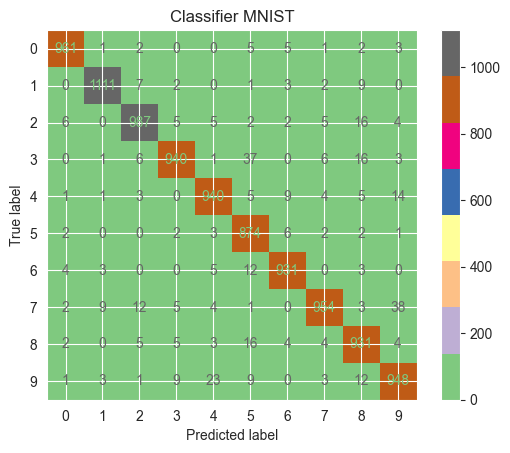

Accuracy: 0.9577

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.93      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.91      0.98      0.94       892
           6       0.97      0.97      0.97       958
           7       0.97      0.93      0.95      1028
           8       0.93      0.96      0.94       974
           9       0.93      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 32, 16
Ep 01/100 | train loss 0.4709 acc 0.8639 | val loss 0.2147 acc 0.9378
Ep 02/100 | train loss 0.2285 acc 0.9331 | val loss 0.1636 acc 0.9525
Ep 03/100 | train loss 0.

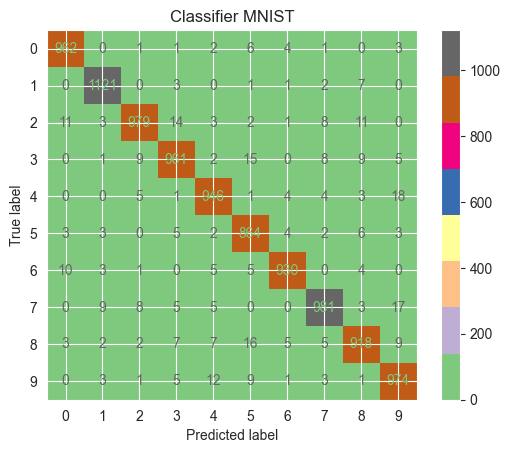

Accuracy: 0.9636

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.94      0.97      0.95       892
           6       0.98      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 32, 32
Ep 01/100 | train loss 0.4446 acc 0.8729 | val loss 0.2305 acc 0.9302
Ep 02/100 | train loss 0.2344 acc 0.9304 | val loss 0.1749 acc 0.9465
Ep 03/100 | train loss 0.

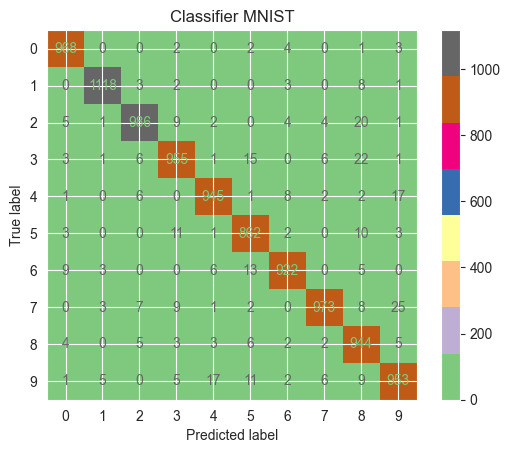

Accuracy: 0.9626

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.97      0.96       892
           6       0.97      0.96      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.92      0.97      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


 Test dla ilości neuronów 32, 64
Ep 01/100 | train loss 0.3880 acc 0.8909 | val loss 0.1857 acc 0.9455
Ep 02/100 | train loss 0.1985 acc 0.9407 | val loss 0.1457 acc 0.9592
Ep 03/100 | train loss 0.

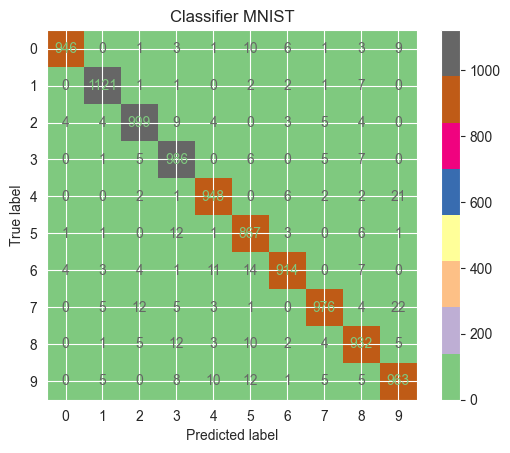

Accuracy: 0.9652

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.94      0.97      0.96       892
           6       0.98      0.95      0.96       958
           7       0.98      0.95      0.96      1028
           8       0.95      0.96      0.96       974
           9       0.94      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 32, 128
Ep 01/100 | train loss 0.3702 acc 0.8921 | val loss 0.1717 acc 0.9517
Ep 02/100 | train loss 0.1770 acc 0.9477 | val loss 0.1206 acc 0.9655
Ep 03/100 | train loss 0

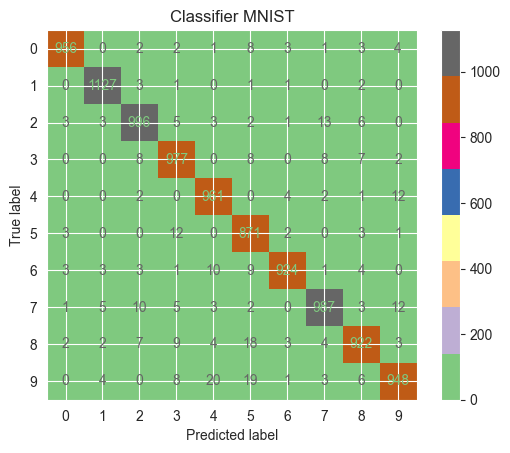

Accuracy: 0.9669

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.93      0.98      0.95       892
           6       0.98      0.96      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 64, 8
Ep 01/100 | train loss 0.5156 acc 0.8519 | val loss 0.2334 acc 0.9348
Ep 02/100 | train loss 0.2332 acc 0.9334 | val loss 0.1667 acc 0.9522
Ep 03/100 | train loss 0.1

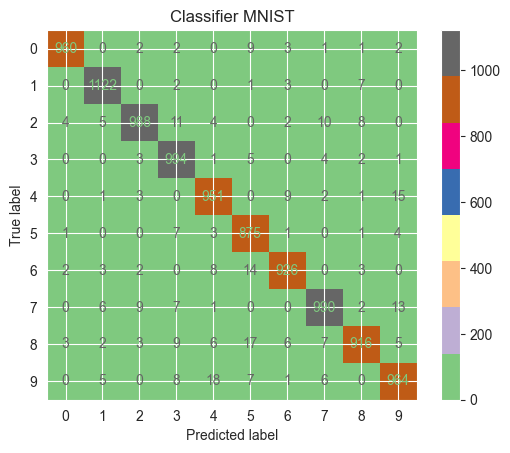

Accuracy: 0.9686

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.97      0.96       982
           5       0.94      0.98      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 64, 16
Ep 01/100 | train loss 0.4306 acc 0.8769 | val loss 0.2046 acc 0.9410
Ep 02/100 | train loss 0.2041 acc 0.9394 | val loss 0.1445 acc 0.9597
Ep 03/100 | train loss 0.

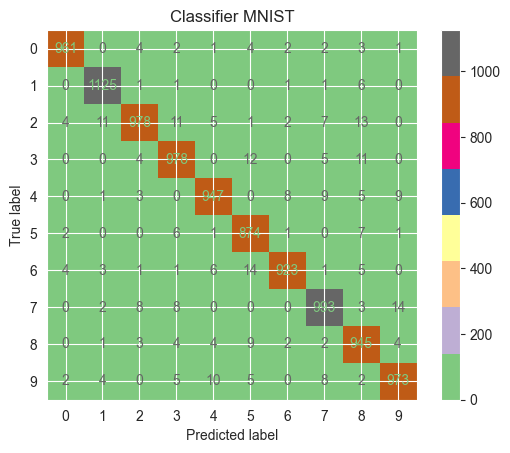

Accuracy: 0.9697

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.95      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.98      0.97       892
           6       0.98      0.96      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.94      0.97      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 64, 32
Ep 01/100 | train loss 0.3757 acc 0.8918 | val loss 0.1809 acc 0.9483
Ep 02/100 | train loss 0.1770 acc 0.9481 | val loss 0.1319 acc 0.9620
Ep 03/100 | train loss 0.

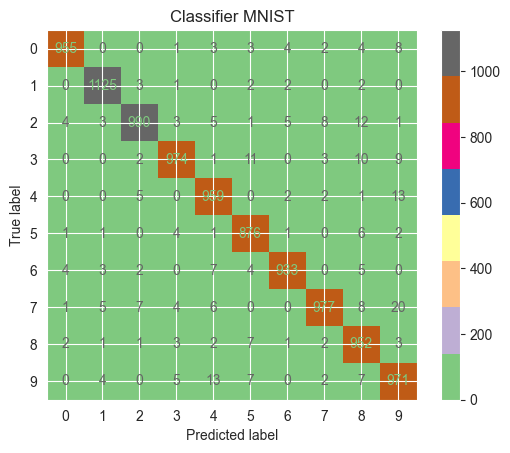

Accuracy: 0.9712

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.98      0.96       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 64, 64
Ep 01/100 | train loss 0.3580 acc 0.8969 | val loss 0.1619 acc 0.9502
Ep 02/100 | train loss 0.1636 acc 0.9509 | val loss 0.1139 acc 0.9657
Ep 03/100 | train loss 0.

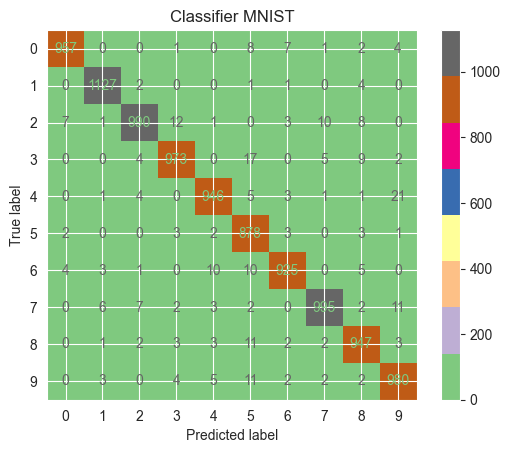

Accuracy: 0.9718

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.93      0.98      0.96       892
           6       0.98      0.97      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 64, 128
Ep 01/100 | train loss 0.3426 acc 0.9008 | val loss 0.1519 acc 0.9562
Ep 02/100 | train loss 0.1525 acc 0.9528 | val loss 0.1107 acc 0.9653
Ep 03/100 | train loss 0

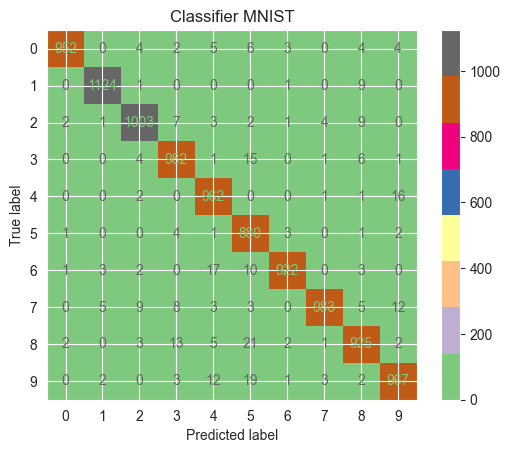

Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.95      0.98      0.97       982
           5       0.92      0.99      0.95       892
           6       0.99      0.96      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 128, 8
Ep 01/100 | train loss 0.4286 acc 0.8769 | val loss 0.1837 acc 0.9473
Ep 02/100 | train loss 0.1740 acc 0.9496 | val loss 0.1318 acc 0.9630
Ep 03/100 | train loss 0.11

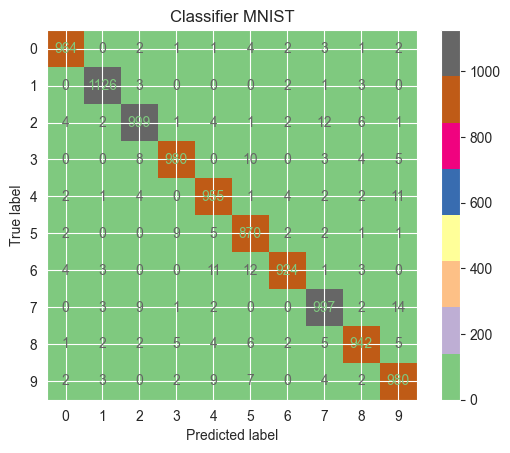

Accuracy: 0.9737

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.96      0.97      0.97       982
           5       0.95      0.98      0.97       892
           6       0.99      0.96      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 128, 16
Ep 01/100 | train loss 0.3777 acc 0.8901 | val loss 0.1703 acc 0.9492
Ep 02/100 | train loss 0.1580 acc 0.9530 | val loss 0.1288 acc 0.9608
Ep 03/100 | train loss 0

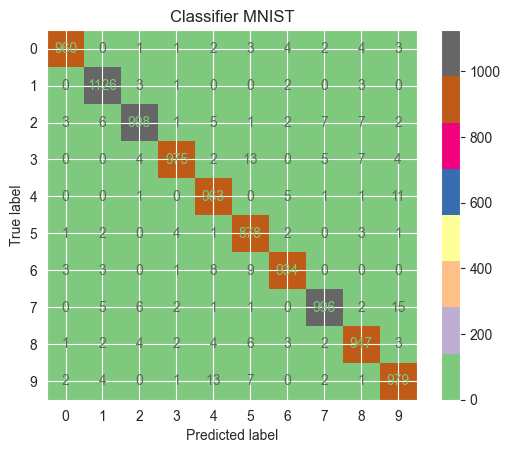

Accuracy: 0.9756

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.96      0.98      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 Test dla ilości neuronów 128, 32
Ep 01/100 | train loss 0.3312 acc 0.9034 | val loss 0.1417 acc 0.9592
Ep 02/100 | train loss 0.1416 acc 0.9579 | val loss 0.1005 acc 0.9688
Ep 03/100 | train loss 0

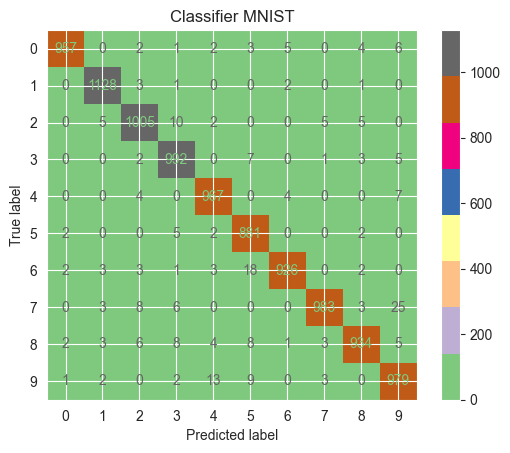

Accuracy: 0.9752

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.95      0.99      0.97       892
           6       0.99      0.97      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000


 Test dla ilości neuronów 128, 64
Ep 01/100 | train loss 0.3130 acc 0.9110 | val loss 0.1348 acc 0.9623
Ep 02/100 | train loss 0.1303 acc 0.9607 | val loss 0.1000 acc 0.9717
Ep 03/100 | train loss 0

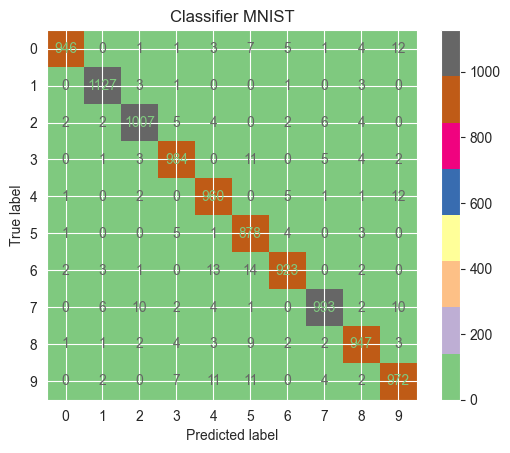

Accuracy: 0.9737

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.94      0.98      0.96       892
           6       0.98      0.96      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Test dla ilości neuronów 128, 128
Ep 01/100 | train loss 0.2970 acc 0.9143 | val loss 0.1272 acc 0.9633
Ep 02/100 | train loss 0.1224 acc 0.9629 | val loss 0.0977 acc 0.9730
Ep 03/100 | train loss 

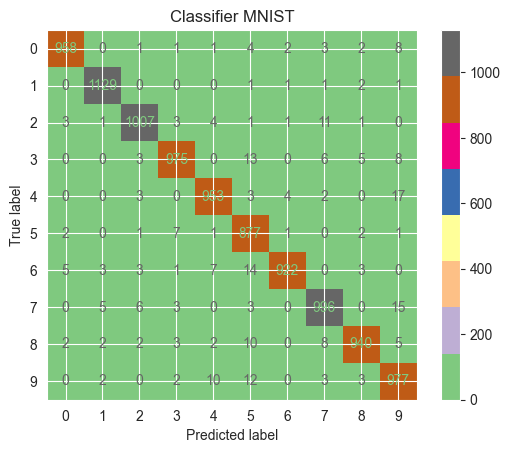

Accuracy: 0.9734

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.93      0.98      0.96       892
           6       0.99      0.96      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [57]:
# kod trenowania
def train():
    EPOCHS = 100  # maksymalnie ile dam epok możliwych
    patience = 2
    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None  # inicjalizacja

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    start = time.time()

    for epoch in range(1, EPOCHS+1):

        tr_loss, tr_acc, _ = run_epoch(train_loader, train=True)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)

        val_loss, val_acc, _ = run_epoch(val_loader, train=False)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Ep {epoch:02d}/{EPOCHS} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.4f}")

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # kopiujemy stan
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹ Early stopping on epoch {epoch}")
                break

    # Załaduj najlepszy model (tylko jeśli znaleziono)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)


# kod testowania
def test():
    # sprawdźmy jak ten model radzi sobie z danymi testowymi
    tr_loss, tr_acc, y_pred = run_epoch(test_loader, train=False)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Accent")
    plt.title("Classifier MNIST")
    plt.show()

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


# testowanie różnych architektur
neural_sizes = [8, 16, 32, 64, 128]

for a in neural_sizes:
    for b in neural_sizes:
        model = NeuralNetwork(input_size=28*28, hidden_size_1=a, hidden_size_2=b, output_size=10).to(device)
        optimizer = optim.Adam(params=model.parameters(), lr=1e-3)  # za każdym razem trzeba dodawać optimizer :(
        criterion = nn.CrossEntropyLoss()  # też od nowa
        print(f"\n Test dla ilości neuronów {a}, {b}")
        train()
        test()

Najlepszy model osiągamy dla liczby neuronów 128 i 8 osiągając prawie 98 dokładność

# Wnioski
Niestety zabrakło mi czasu na głębszą analizę tego zadania :(
- Najczęściej mylonymi liczbami są 6 i 5, 9 i 3, 7 i 9 z powodu podobieństw tych liczb
- Za dobry wynik możemy uznać dokładność na poziomie powyżej 90 oraz bycie lepszym od dummy
- W czasie treningu powinniśmy przerywać go gdy dokładność na zbiorze walidacyjnym zaczyna spadać